Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре). 
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

from tqdm.auto import tqdm
from pymystem3 import Mystem
mystem = Mystem()

In [2]:
wiki = open('data/wiki_data.txt', 'r', encoding='utf-8').read().split('\n')

In [3]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

Добавил лемматизацию через pymorphy3

In [28]:
from pymorphy3 import MorphAnalyzer
import re
def preprocess(text):
    morph = MorphAnalyzer()
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    tokens = [morph.parse(token)[0].normal_form for token in tokens]
    return tokens

In [29]:
text = 'голоса в моей голове'

preprocess(text)

['голос', 'в', 'мой', 'голова']

In [32]:
vocab = Counter()

for text in tqdm(wiki):
    vocab.update(preprocess(text))


  0%|          | 0/20003 [00:00<?, ?it/s]

In [33]:
vocab.most_common(10)

[('в', 275172),
 ('и', 146585),
 ('год', 94984),
 ('на', 81230),
 ('—', 67491),
 ('с', 65101),
 ('быть', 58292),
 ('он', 38697),
 ('по', 36506),
 ('из', 26665)]

In [34]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

len(filtered_vocab)

12460

In [35]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [36]:
id2word = {i:word for word, i in word2id.items()}

In [37]:
sentences = []

for text in tqdm(wiki):
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

  0%|          | 0/20003 [00:00<?, ?it/s]

Изменил окно в большую сторону

In [38]:
vocab_size = len(id2word)

In [39]:
# skip gram
def gen_batches_sg(sentences, window = 7, batch_size=1000):
    
    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []


In [40]:
# # cbow 
def gen_batches_cbow(sentences, window = 7, batch_size=1000):
    
    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

Размер итогового вектора установил 200

In [41]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_1 = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])




In [43]:
model_1.fit(gen_batches_sg(sentences[:19000], window=7),
          validation_data=gen_batches_sg(sentences[19000:],  window=7),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
10000/10000 [==============================] - 2168s 217ms/step - loss: 0.3857 - accuracy: 0.8322 - val_loss: 0.3874 - val_accuracy: 0.8381
Epoch 2/2
10000/10000 [==============================] - 740s 74ms/step - loss: 0.3780 - accuracy: 0.8356 - val_loss: 0.4002 - val_accuracy: 0.8220


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


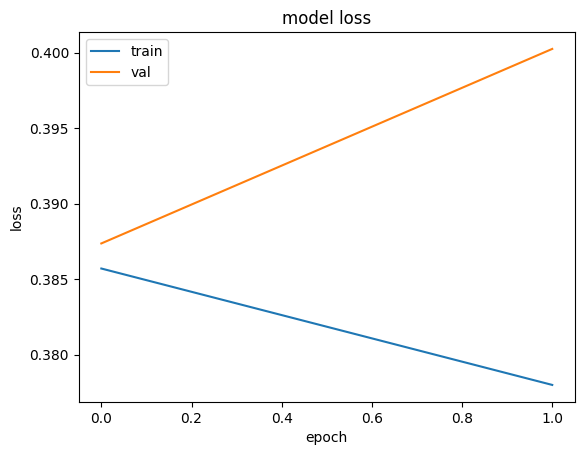

In [44]:
print(model_1.history.history.keys())
# summarize history for accuracy
plt.plot(model_1.history.history['loss'])
plt.plot(model_1.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
embeddings = model_1.layers[2].get_weights()[0]

In [127]:
embeddings[0]

<KerasTensor: shape=(100, 100) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [46]:
most_similar('церковь', embeddings)

['церковь',
 'православный',
 'храм',
 'собор',
 'монастырь',
 'святой',
 'святитель',
 'чудотворец',
 'лик',
 'часовня']

In [47]:
most_similar('кран', embeddings)

['кран',
 'орель',
 'тимор',
 'дятел',
 'надир',
 'чугун',
 'валериан',
 'воспитательный',
 'куско',
 'вертеп']

In [48]:
most_similar('офис', embeddings)

['офис',
 'коммерческий',
 'исследовательский',
 'персонал',
 'корпорация',
 'дирекция',
 'бельгийский',
 'ооо',
 'банк',
 'компания']

In [49]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_2 = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [50]:
model_2.fit(gen_batches_cbow(sentences[:19000], window=7),
          validation_data=gen_batches_cbow(sentences[19000:],  window=7),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 [==============================] - 217s 43ms/step - loss: 0.3715 - accuracy: 0.8399 - val_loss: 0.3131 - val_accuracy: 0.8721
Epoch 2/2
5000/5000 [==============================] - 217s 43ms/step - loss: 0.2815 - accuracy: 0.8842 - val_loss: 0.2622 - val_accuracy: 0.8937


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


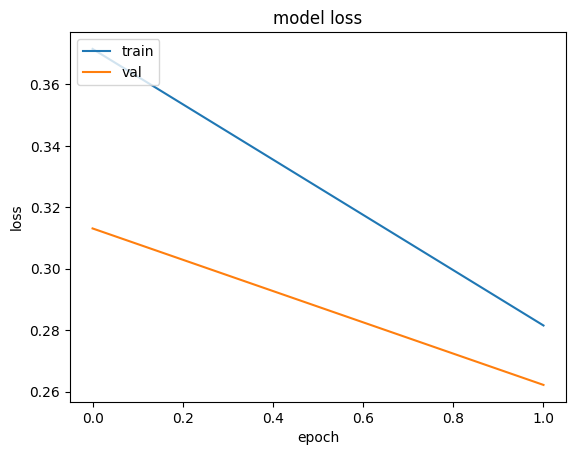

In [51]:
print(model_2.history.history.keys())
# summarize history for accuracy
plt.plot(model_2.history.history['loss'])
plt.plot(model_2.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
embeddings = model_2.layers[2].get_weights()[0]

In [53]:
most_similar('церковь', embeddings)

['церковь',
 'монастырь',
 'храм',
 'собор',
 'святой',
 'церковный',
 'православный',
 'епископ',
 'община',
 'икона']

In [54]:
most_similar('кран', embeddings)

['кран',
 'gt8',
 'накопитель',
 'девятаев',
 'порошок',
 'резервуар',
 'орбитальный',
 'бизоновый',
 'съёмный',
 'электрохимический']

In [55]:
most_similar('офис', embeddings)

['офис',
 'розничный',
 'столовая',
 'страховой',
 'отель',
 'гараж',
 'кафе',
 'контора',
 'котельная',
 'бар']

---------------

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [57]:
# !pip install gensim

In [58]:
import gensim

In [61]:
wiki = open('data/wiki_data.txt', 'r', encoding='utf-8').read().split('\n')

In [62]:
texts = [preprocess(text) for text in wiki]

In [126]:
w2v = gensim.models.Word2Vec(texts,
                             hs=0,
                             negative=10,
                             sample=1e-4,
                             vector_size=200, 
                             min_count=5, 
                             max_vocab_size=10000,
                             window=7,
                             epochs=10)

In [64]:
w2v.wv.most_similar('церковь')

[('монастырь', 0.9306808114051819),
 ('храм', 0.9186384677886963),
 ('собор', 0.9034382700920105),
 ('богородица', 0.8960888385772705),
 ('православный', 0.8947327733039856),
 ('святитель', 0.873807966709137),
 ('приход', 0.8639441728591919),
 ('епархия', 0.86221843957901),
 ('часовня', 0.8506441712379456),
 ('икона', 0.84366375207901)]

In [66]:
w2v.wv.most_similar('автомобиль')

[('шасси', 0.9046242833137512),
 ('двигатель', 0.8783441185951233),
 ('модель', 0.8500972986221313),
 ('модификация', 0.8255156874656677),
 ('кузов', 0.8221611976623535),
 ('benetton', 0.7749459743499756),
 ('машина', 0.7700903415679932),
 ('улучшить', 0.7595919370651245),
 ('автоматический', 0.7594683766365051),
 ('моторный', 0.7491530179977417)]

In [125]:
ft = gensim.models.FastText(texts, min_n=4, max_n=10, window=10, epochs=10)

In [68]:
ft.wv.most_similar('церковь')

[('«церковь', 0.9972864985466003),
 ('церковь»', 0.9966346621513367),
 ('це́рковь', 0.9856696128845215),
 ('церква', 0.9681044816970825),
 ('церкви»', 0.9466263055801392),
 ('морковь', 0.9052931070327759),
 ('архипастырь', 0.869535505771637),
 ('монастырь', 0.8678775429725647),
 ('монастыря»', 0.8670889735221863),
 ('церн', 0.8595736622810364)]

In [69]:
ft.wv.most_similar('автомобиль')

[('спецавтомобиль', 0.9892289638519287),
 ('локомобиль', 0.9556282162666321),
 ('бронеавтомобиль', 0.9403617978096008),
 ('автомобилист', 0.9214709997177124),
 ('автомотриса', 0.8985264897346497),
 ('нобиль', 0.8800316452980042),
 ('«автомобилист»', 0.8692030310630798),
 ('автомат', 0.8387049436569214),
 ('автомобильный', 0.8197221159934998),
 ('вятка-автомат', 0.8188124895095825)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [71]:
data = pd.read_csv('data/labeled.csv')

In [72]:
data['norm_text'] = data.comment.apply(preprocess)

In [73]:
vocab1 = Counter()

for text in data['norm_text']:
    vocab1.update(text)
    
filtered_vocab1 = set()

for word in vocab:
    if vocab1[word] > 5:
        filtered_vocab1.add(word)

len(filtered_vocab1)

5792

In [ ]:
word2id1 = { 'PAD':0}

for word in filtered_vocab1:
    word2id1[word] = len(word2id1)
id2word1 = {i:word for word, i in word2id1.items()}

In [75]:
X = []

for tokens in data['norm_text']:
    ids = [word2id1[token] for token in tokens if token in word2id1]
    X.append(ids)

In [76]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [77]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [123]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
# embedding слой возвращает последовательность векторов
# а нам нужно классифицировать сразу весь текст
# стандартный подход в этом случае - усреднить единичные вектора в 1 вектор текста
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
# к усредненному вектору мы уже применяем полносвязный слой, который вернет вероятность токсичности
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [124]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=10)

Epoch 1/10
428/428 [==============================] - 6s 12ms/step - loss: 0.6153 - accuracy: 0.6636 - val_loss: 0.5748 - val_accuracy: 0.6574
Epoch 2/10
428/428 [==============================] - 5s 11ms/step - loss: 0.5294 - accuracy: 0.7184 - val_loss: 0.4870 - val_accuracy: 0.7573
Epoch 3/10
428/428 [==============================] - 5s 11ms/step - loss: 0.4392 - accuracy: 0.8121 - val_loss: 0.4163 - val_accuracy: 0.8169
Epoch 4/10
428/428 [==============================] - 5s 11ms/step - loss: 0.3756 - accuracy: 0.8584 - val_loss: 0.3800 - val_accuracy: 0.8599
Epoch 5/10
428/428 [==============================] - 5s 11ms/step - loss: 0.3339 - accuracy: 0.8771 - val_loss: 0.3563 - val_accuracy: 0.8585
Epoch 6/10
428/428 [==============================] - 5s 11ms/step - loss: 0.3041 - accuracy: 0.8883 - val_loss: 0.3418 - val_accuracy: 0.8433
Epoch 7/10
428/428 [==============================] - 5s 12ms/step - loss: 0.2816 - accuracy: 0.8957 - val_loss: 0.3398 - val_accuracy: 0.8322

In [112]:
word2id1['погашение']

1

In [ ]:
emb1[0][word2id1['погашение']]

In [137]:
emb1 = model_1.layers[2].get_weights()

In [ ]:
weights_c1 = np.zeros((len(word2id), 200))
emb1 = model_1.layers[2].get_weights()

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights_c1[i] = emb1[0][word2id[word]]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights_c1[i] = emb1[0][word2id['опрагпллирао']]

In [152]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200, 
                                       trainable=False,
                                       weights=[weights_c1])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [153]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 3s 4ms/step - loss: 0.6457 - accuracy: 0.6636 - val_loss: 0.6260 - val_accuracy: 0.6574
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6205 - accuracy: 0.6655 - val_loss: 0.6206 - val_accuracy: 0.6574
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6180 - accuracy: 0.6655 - val_loss: 0.6192 - val_accuracy: 0.6574
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6171 - accuracy: 0.6655 - val_loss: 0.6181 - val_accuracy: 0.6574
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6164 - accuracy: 0.6655 - val_loss: 0.6171 - val_accuracy: 0.6574
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6157 - accuracy: 0.6655 - val_loss: 0.6161 - val_accuracy: 0.6574
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6150 - accuracy: 0.6655 - val_loss: 0.6153 - val_accuracy: 0.6574
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


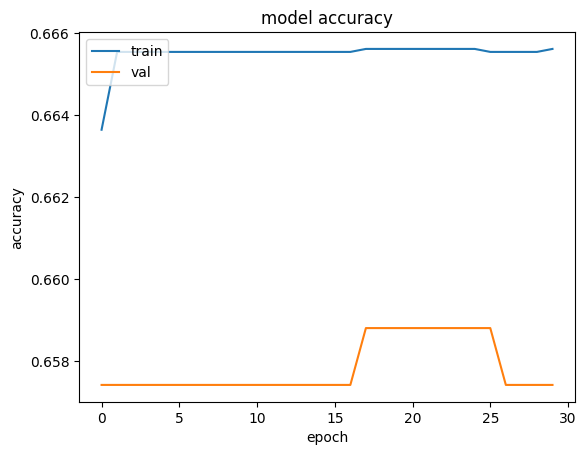

In [154]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [156]:
weights_c2 = np.zeros((len(word2id), 200))
emb2 = model_2.layers[2].get_weights()

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights_c2[i] = emb2[0][word2id[word]]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights_c2[i] = emb2[0][word2id['опрагпллирао']]

In [160]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200, 
                                       trainable=False,
                                       weights=[weights_c2])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [161]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 3s 4ms/step - loss: 0.6444 - accuracy: 0.6655 - val_loss: 0.6254 - val_accuracy: 0.6574
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6199 - accuracy: 0.6655 - val_loss: 0.6203 - val_accuracy: 0.6574
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6177 - accuracy: 0.6655 - val_loss: 0.6189 - val_accuracy: 0.6574
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6169 - accuracy: 0.6655 - val_loss: 0.6178 - val_accuracy: 0.6574
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6161 - accuracy: 0.6655 - val_loss: 0.6168 - val_accuracy: 0.6574
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6154 - accuracy: 0.6655 - val_loss: 0.6159 - val_accuracy: 0.6574
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6148 - accuracy: 0.6655 - val_loss: 0.6151 - val_accuracy: 0.6574
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


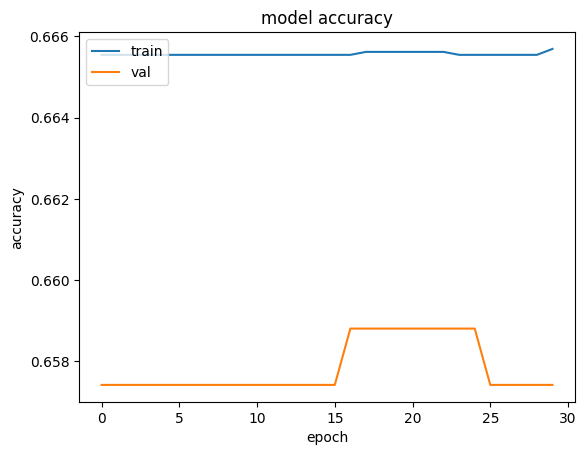

In [162]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [163]:
weights_c3 = np.zeros((len(word2id), 200))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights_c3[i] = w2v.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights_c3[i] = w2v.wv['опрагпллирао']

In [165]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200, 
                                       trainable=False,
                                       weights=[weights_c3])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [166]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 3s 4ms/step - loss: 0.6443 - accuracy: 0.6651 - val_loss: 0.6245 - val_accuracy: 0.6574
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6196 - accuracy: 0.6655 - val_loss: 0.6199 - val_accuracy: 0.6574
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6175 - accuracy: 0.6655 - val_loss: 0.6186 - val_accuracy: 0.6574
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6167 - accuracy: 0.6655 - val_loss: 0.6175 - val_accuracy: 0.6574
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6160 - accuracy: 0.6655 - val_loss: 0.6165 - val_accuracy: 0.6574
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6154 - accuracy: 0.6655 - val_loss: 0.6156 - val_accuracy: 0.6574
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6147 - accuracy: 0.6655 - val_loss: 0.6148 - val_accuracy: 0.6574
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


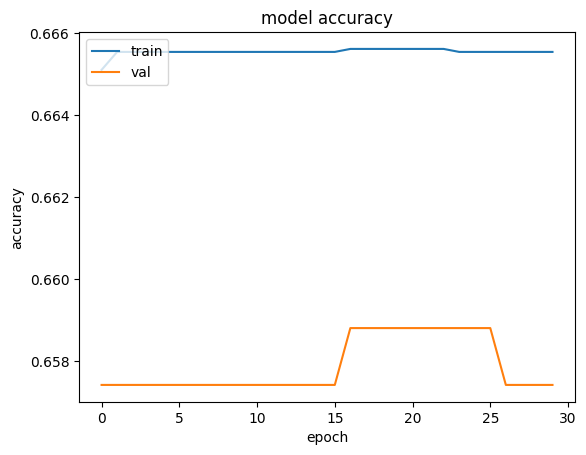

In [167]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [168]:
weights_c4 = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights_c4[i] = ft.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights_c4[i] = ft.wv['опрагпллирао']

In [170]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200, 
                                       trainable=False,
                                       weights=[weights_c4])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [171]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 3ms/step - loss: 0.6428 - accuracy: 0.6655 - val_loss: 0.6247 - val_accuracy: 0.6574
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6195 - accuracy: 0.6655 - val_loss: 0.6205 - val_accuracy: 0.6574
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6177 - accuracy: 0.6655 - val_loss: 0.6193 - val_accuracy: 0.6574
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6169 - accuracy: 0.6655 - val_loss: 0.6182 - val_accuracy: 0.6574
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6162 - accuracy: 0.6655 - val_loss: 0.6171 - val_accuracy: 0.6574
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6155 - accuracy: 0.6655 - val_loss: 0.6162 - val_accuracy: 0.6574
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6148 - accuracy: 0.6655 - val_loss: 0.6154 - val_accuracy: 0.6574
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


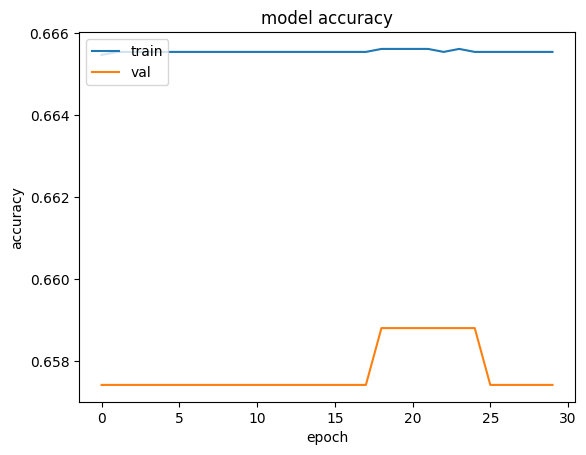

In [172]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Предобученная модель

In [175]:
model = gensim.models.KeyedVectors.load_word2vec_format('data/ruscorpora_upos_skipgram_300_5_2018.vec', binary=False)

In [ ]:
model['март_NOUN']

In [177]:
model.most_similar('февраль_NOUN')

[('март_NOUN', 0.9469264149665833),
 ('январь_NOUN', 0.9385507702827454),
 ('декабрь_NOUN', 0.9291070699691772),
 ('ноябрь_NOUN', 0.9287325739860535),
 ('апрель_NOUN', 0.9180451035499573),
 ('октябрь_NOUN', 0.9116759300231934),
 ('май_NOUN', 0.8881860375404358),
 ('сентябрь_NOUN', 0.884035050868988),
 ('июнь_NOUN', 0.8719688057899475),
 ('август_NOUN', 0.8699690699577332)]

In [179]:
mapping = {}

for line in open('data/ru-rnc.map'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [180]:
from pymystem3 import Mystem
m = Mystem()

In [181]:

def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens


In [182]:
data['norm_text_2'] = data.comment.apply(normalize_mystem)

In [ ]:
vocab1 = Counter()

for text in data['norm_text_2']:
    vocab1.update(text)
    
filtered_vocab1 = set()

for word in vocab:
    if vocab1[word] > 5:
        filtered_vocab1.add(word)

len(filtered_vocab1)

In [ ]:
word2id1 = { 'PAD':0}

for word in filtered_vocab1:
    word2id1[word] = len(word2id1)
id2word1 = {i:word for word, i in word2id1.items()}

In [ ]:
X = []

for tokens in data['norm_text_2']:
    ids = [word2id1[token] for token in tokens if token in word2id1]
    X.append(ids)

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [ ]:
weights_c5 = np.zeros((len(word2id1), 200))

for word, i in word2id1.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights_c5[i] = model.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights_c5[i] = model.wv['опрагпллирао']

In [ ]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id1), output_dim=200, 
                                       trainable=False,
                                       weights=[weights_c5])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Лучше других показала себя предобученная модель